In [62]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
)

In [63]:
df = pd.read_csv("../data/processed/oversampled_heart_disease_dataset.csv")

In [64]:
df.shape

(6300, 16)

In [65]:
target_col = 'TenYearCHD'

X = df.drop(columns=[target_col])
y = df[target_col]

In [66]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Sequential Feature Selection


Running SFS (ROC AUC) for Logistic Regression...
1
2
3
4
5
6
7
8
9
10
11
12
13
14

Running SFS (ROC AUC) for KNN (k=5)...
1
2
3
4
5
6
7
8
9
10
11
12
13
14

Running SFS (ROC AUC) for Random Forest...
1
2
3
4
5
6
7
8
9
10
11
12
13
14

Running SFS (ROC AUC) for dt...
1
2
3
4
5
6
7
8
9
10
11
12
13
14

Running SFS (ROC AUC) for xg...
1
2
3
4
5
6
7
8
9
10
11
12
13
14


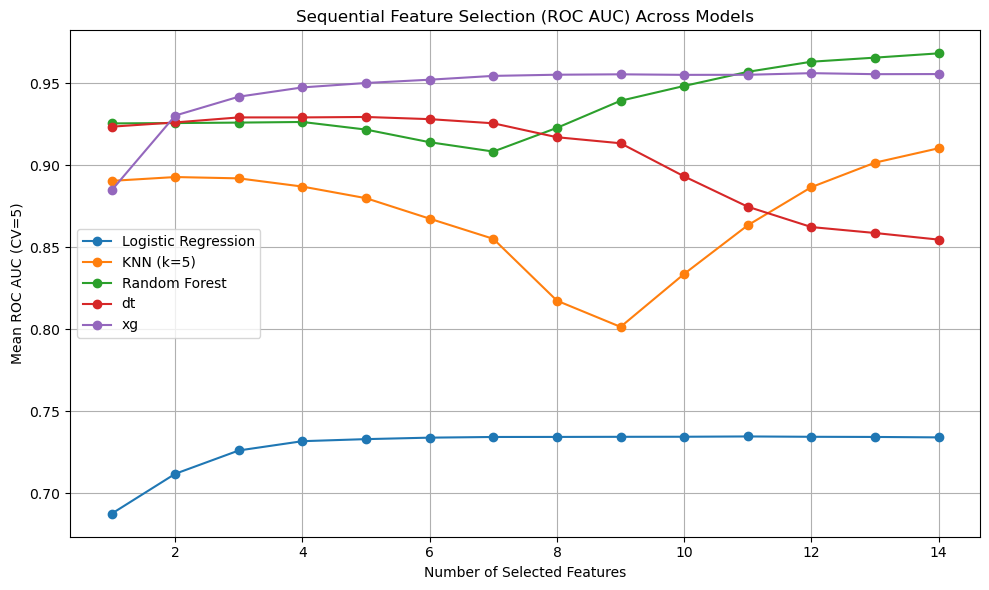


=== Best ROC AUC per Model ===
Logistic Regression: Best ROC AUC = 0.7346 with 11 features
KNN (k=5): Best ROC AUC = 0.9103 with 14 features
Random Forest: Best ROC AUC = 0.9682 with 14 features
dt: Best ROC AUC = 0.9294 with 5 features
xg: Best ROC AUC = 0.9561 with 12 features


In [74]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(
                        criterion='entropy',
                        max_depth=None,
                        max_features='sqrt',
                        min_samples_leaf=1,
                        min_samples_split=2,
                        n_estimators=200,
                        random_state=42
                    ),
    "dt": DecisionTreeClassifier(
                criterion='entropy', 
                max_depth=None, 
                min_samples_leaf=5, 
                min_samples_split=2
            ),
    "xg": xgb.XGBClassifier(
            colsample_bytree=1.0, 
            learning_rate=0.1, 
            max_depth=5, 
            n_estimators=200, 
            subsample=0.8
        )
}

feature_counts = range(1, X.shape[1])

results = {}

for model_name, model in models.items():
    print(f"\nRunning SFS (ROC AUC) for {model_name}...")
    scores = []
    
    for k in feature_counts:
        sfs = SequentialFeatureSelector(
            model,
            n_features_to_select=k,
            cv=5,
            n_jobs=-1,
            scoring='roc_auc'  
        )
        print(k)
        sfs.fit(X, y)

        X_sfs = sfs.transform(X)
        score = cross_val_score(
            model, X_sfs, y, cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        scores.append(score)

    results[model_name] = scores

plt.figure(figsize=(10, 6))
for model_name, scores in results.items():
    plt.plot(feature_counts, scores, marker='o', label=model_name)

plt.xlabel("Number of Selected Features")
plt.ylabel("Mean ROC AUC (CV=5)")
plt.title("Sequential Feature Selection (ROC AUC) Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Best ROC AUC per Model ===")
for model_name, scores in results.items():
    best_k = np.argmax(scores) + 1
    best_score = max(scores)
    print(f"{model_name}: Best ROC AUC = {best_score:.4f} with {best_k} features")

In [76]:
from sklearn.feature_selection import SequentialFeatureSelector
import pandas as pd

# --- Setup ---
# (Make sure these variables are defined)
# X_train, y_train = ...
# dt, rf, knn, xg, lr = ... (your initialized models)

# Get the list of all your feature names
all_feature_names = X_train.columns

# A dictionary to store our final results
best_feature_sets = {}

# --- 1. Decision Tree (Best was 5 features) ---
print("Running SFS for Decision Tree (n=5)...")
sfs_dt = SequentialFeatureSelector(
    dt, 
    n_features_to_select=5,  # Use the number you found
    cv=5, 
    scoring='roc_auc'
)
sfs_dt.fit(X_train, y_train)
mask_dt = sfs_dt.get_support()
best_feature_sets['Decision Tree'] = list(all_feature_names[mask_dt])


# --- 2. Random Forest (Best was 14 features) ---
print("Running SFS for Random Forest (n=14)...")
sfs_rf = SequentialFeatureSelector(
    rf, 
    n_features_to_select=14, # Use the number you found
    cv=5, 
    scoring='roc_auc'
)
sfs_rf.fit(X_train, y_train)
mask_rf = sfs_rf.get_support()
best_feature_sets['Random Forest'] = list(all_feature_names[mask_rf])


# --- 3. KNN (Best was 14 features) ---
print("Running SFS for KNN (n=14)...")
sfs_knn = SequentialFeatureSelector(
    knn, 
    n_features_to_select=14, # Use the number you found
    cv=5, 
    scoring='roc_auc'
)
sfs_knn.fit(X_train, y_train)
mask_knn = sfs_knn.get_support()
best_feature_sets['KNN'] = list(all_feature_names[mask_knn])


# --- 4. XGBoost (Best was 12 features) ---
print("Running SFS for XGBoost (n=12)...")
sfs_xg = SequentialFeatureSelector(
    xg, 
    n_features_to_select=12, # Use the number you found
    cv=5, 
    scoring='roc_auc'
)
sfs_xg.fit(X_train, y_train)
mask_xg = sfs_xg.get_support()
best_feature_sets['XGBoost'] = list(all_feature_names[mask_xg])


# --- 5. Logistic Regression (Best was 11 features) ---
print("Running SFS for Logistic Regression (n=11)...")
sfs_lr = SequentialFeatureSelector(
    lr, 
    n_features_to_select=11, # Use the number you found
    cv=5, 
    scoring='roc_auc'
)
sfs_lr.fit(X_train, y_train)
mask_lr = sfs_lr.get_support()
best_feature_sets['Logistic Regression'] = list(all_feature_names[mask_lr])


# --- Now, print all the results ---
print("\n=== Best Feature Sets per Model ===")
for model_name, features in best_feature_sets.items():
    print(f"\n--- {model_name} ({len(features)} features) ---")
    print(features)

Running SFS for Decision Tree (n=5)...
Running SFS for Random Forest (n=14)...
Running SFS for KNN (n=14)...
Running SFS for XGBoost (n=12)...


NameError: name 'xg' is not defined

In [77]:
# --- Now, print all the results ---
print("\n=== Best Feature Sets per Model ===")
for model_name, features in best_feature_sets.items():
    print(f"\n--- {model_name} ({len(features)} features) ---")
    print(features)


=== Best Feature Sets per Model ===

--- Decision Tree (5 features) ---
['male', 'age', 'education', 'prevalentStroke', 'diabetes']

--- Random Forest (14 features) ---
['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

--- KNN (14 features) ---
['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose']


In [79]:
# Transform training and test data to selected features
X_train_sfs = sfs_dt.transform(X_train)
X_test_sfs = sfs_dt.transform(X_test)

# Fit the classifier using selected features
dt.fit(X_train_sfs, y_train)

# Make predictions
y_pred = dt.predict(X_test_sfs)


Confusion Matrix:
 [[609  21]
 [ 99 531]]


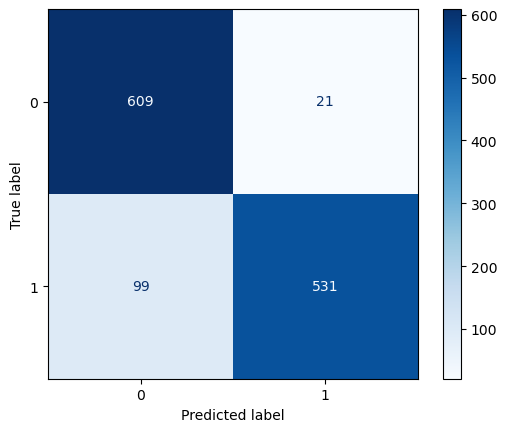

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the raw matrix
print("Confusion Matrix:\n", cm)

# Optional: Pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

# Create a logistic regression model
model = RandomForestClassifier(
    criterion='entropy',
    max_depth=None,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # optional, uses all CPU cores
)

# Create a sequential feature selector
selector = SequentialFeatureSelector(
    model, n_features_to_select=8, scoring='roc_auc')

# Fit the selector to the data
selector.fit(X, y)

# Get the selected features
selected_features = selector.get_support()

print('The selected features are:', list(X.columns[selected_features]))

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [90]:
model.fit(X_train[list(X.columns[selected_features])], y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=200, n_jobs=-1, random_state=42)

In [91]:
y_pred = model.predict(X_test[list(X.columns[selected_features])])
y_prob = model.predict_proba(X_test[list(X.columns[selected_features])])[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.4f}")

Accuracy on test data: 0.8889


In [92]:
precision_score(y_test, y_pred)

0.8769230769230769

In [93]:
recall_score(y_test, y_pred)

0.9047619047619048

In [94]:
roc_auc_score(y_test, y_prob)

np.float64(0.9568619299571681)

In [98]:
import numpy as np

def sequential_forward_selection(X, y, model, num_features=None):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    best_score = -np.inf  # To track the best score

    while remaining_features:
        scores_with_candidates = []
        for feature in remaining_features:
            # Add the candidate feature to the selected ones
            current_features = selected_features + [feature]
            # Evaluate the model performance with the new feature subset
            score = np.mean(cross_val_score(model, X.iloc[:, current_features], y, cv=5, scoring='recall'))
            scores_with_candidates.append((score, feature))
        
        # Sort and pick the best feature
        scores_with_candidates.sort(reverse=True, key=lambda x: x[0])
        best_score_for_this_step, best_feature = scores_with_candidates[0]
        
        if best_score_for_this_step > best_score:  # If we improved the score
            best_score = best_score_for_this_step
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break  # If no improvement, stop

    return selected_features, best_score

# Run Forward Selection
selected_features, best_score = sequential_forward_selection(X, y, model)
print("Selected features:", selected_features)
print("Best score:", best_score)


Selected features: [8]
Best score: 0.9990476190476191


### Greedy Forward Feature Selection

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

selected_features = []
remaining_features = list(X.columns)
best_score = 0

while remaining_features:
    scores = []
    for feature in remaining_features:
        trial_features = selected_features + [feature]
        model = RandomForestClassifier(
            criterion='entropy',
            max_depth=None,
            max_features='log2',
            min_samples_leaf=1,
            min_samples_split=2,
            n_estimators=200,
            random_state=42,
            n_jobs=-1  # optional, uses all CPU cores
        )
        score = cross_val_score(model, X[trial_features], y, scoring='recall', cv=5).mean()
        scores.append((feature, score))
    feature, score = max(scores, key=lambda x: x[1])
    print(feature)
    print(score)
    if score > best_score:
        best_score = score
        selected_features.append(feature)
        remaining_features.remove(feature)
    else:
        break

print("Optimal features:", selected_features)


diabetes
0.9990476190476191
prevalentStroke
0.799047619047619
Optimal features: ['diabetes']


In [80]:
model.fit(X_train[['age', 'diabetes', 'prevalentStroke', 'male']], y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=200, n_jobs=-1, random_state=42)

In [81]:
y_pred = model.predict(X_test[['age', 'diabetes', 'prevalentStroke', 'male']])
y_prob = model.predict_proba(X_test[['age', 'diabetes', 'prevalentStroke', 'male']])[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.4f}")

Accuracy on test data: 0.8944


In [82]:
precision_score(y_test, y_pred)

0.9751434034416826

In [83]:
recall_score(y_test, y_pred)

0.8095238095238095

In [84]:
roc_auc_score(y_test, y_prob)

np.float64(0.9419047619047618)

In [85]:
f1_score(y_test, y_pred)

0.8846487424111015

Confusion Matrix:
[[617  13]
 [120 510]]


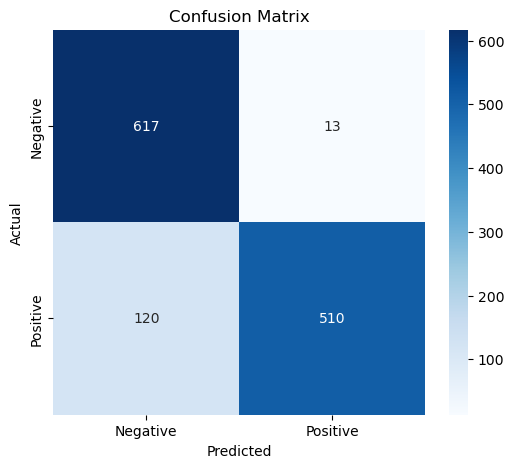

In [86]:


cm = confusion_matrix(y_test, y_pred)

# Step 3: Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
remaining = list(X.columns)
selected = []
best_selected = []
best_score = 0
model = RandomForestClassifier(random_state=42)

while remaining:
    scores = []
    for feature in remaining:
        trial = selected + [feature]
        score = cross_val_score(model, X[trial], y, cv=5, scoring='roc_auc').mean()
        scores.append((feature, score))

    feature, score = max(scores, key=lambda x: x[1])
    selected.append(feature)
    remaining.remove(feature)
    print(feature)
    print(score)
    if score > best_score:
        best_score = score
        best_selected = selected.copy()  # store best subset

# Backward elimination refinement
for feature in best_selected.copy():
    trial = [f for f in best_selected if f != feature]
    score = cross_val_score(model, X[trial], y, cv=cv, scoring=scoring).mean()
    if score >= best_score:
        best_selected.remove(feature)
        best_score = score

print("Optimal features:", best_selected)

age
0.9254303350970016
diabetes
0.9256177878558832
prevalentStroke
0.9258911564625849
male
0.926485764676241
BPMeds
0.9218531116150164
prevalentHyp
0.9134764424288233
currentSmoker
0.9054842529604434
cigsPerDay
0.9014877802973041
heartRate
0.9091050642479214
glucose
0.9309009826152683
sysBP
0.9449821113630638
education
0.9544794658604182
totChol
0.9607283950617284
BMI
0.9629138321995464
diaBP
0.9668929201310155


NameError: name 'cv' is not defined

In [12]:
best_selected

['age',
 'diabetes',
 'prevalentStroke',
 'male',
 'BPMeds',
 'prevalentHyp',
 'currentSmoker',
 'cigsPerDay',
 'heartRate',
 'glucose',
 'sysBP',
 'education',
 'totChol',
 'BMI',
 'diaBP']

In [13]:
for feature in best_selected.copy():
    trial = [f for f in best_selected if f != feature]
    score = cross_val_score(model, X[trial], y, cv=5, scoring='roc_auc').mean()
    if score >= best_score:
        best_selected.remove(feature)
        best_score = score

print("Optimal features:", best_selected)

Optimal features: ['age', 'diabetes', 'prevalentStroke', 'male', 'BPMeds', 'prevalentHyp', 'currentSmoker', 'cigsPerDay', 'heartRate', 'glucose', 'sysBP', 'education', 'totChol', 'BMI', 'diaBP']


## Recursive Elimination

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

15 features → Accuracy: 0.9294, ROC-AUC: 0.9774
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → Accuracy: 0.9238, ROC-AUC: 0.9773
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → Accuracy: 0.9206, ROC-AUC: 0.9772
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
12 features → Accuracy: 0.9151, ROC-AUC: 0.9751
Current feature set: 

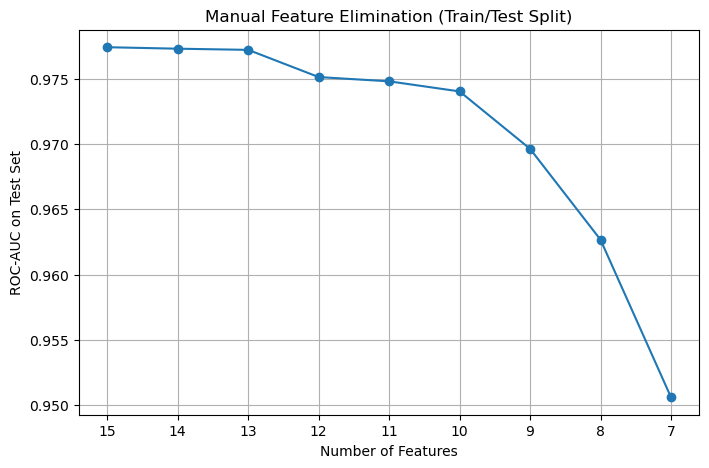

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# === Random Forest with your best parameters ===
rf = RandomForestClassifier(
    criterion='entropy',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# === Track results ===
scores_list = []
n_features_list = []
feature_sets = []

current_features = list(X_train.columns)
prev_score = 0

while len(current_features) > 1:
    # Train model
    rf.fit(X_train[current_features], y_train)
    y_pred = rf.predict(X_test[current_features])
    y_prob = rf.predict_proba(X_test[current_features])[:, 1]

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    scores_list.append(roc)
    n_features_list.append(len(current_features))
    feature_sets.append(current_features.copy())

    print(f"{len(current_features):2d} features → Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}")
    print("Current feature set:", current_features)
    print("-" * 80)

    # Get feature importances
    importances = pd.Series(rf.feature_importances_, index=current_features)
    least_important = importances.idxmin()

    # Drop least important feature
    current_features.remove(least_important)

    # Optional early stop if ROC drops > 1%
    if prev_score and (roc < prev_score - 0.01):
        print("Performance dropped significantly. Stopping.")
        break
    prev_score = roc

# === Plot performance ===
plt.figure(figsize=(8,5))
plt.plot(n_features_list, scores_list, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("Number of Features")
plt.ylabel("ROC-AUC on Test Set")
plt.title("Manual Feature Elimination (Train/Test Split)")
plt.grid(True)
plt.show()


In [34]:
best_features = feature_sets[-2]   # one step before performance dropped
print("Selected optimal features:", best_features)

rf.fit(X_train[best_features], y_train)
y_pred = rf.predict(X_test[best_features])
y_prob = rf.predict_proba(X_test[best_features])[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Selected optimal features: ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

Accuracy: 0.8888888888888888
ROC-AUC: 0.9626681783824641

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       630
           1       0.87      0.91      0.89       630

    accuracy                           0.89      1260
   macro avg       0.89      0.89      0.89      1260
weighted avg       0.89      0.89      0.89      1260


Confusion Matrix:
 [[546  84]
 [ 56 574]]


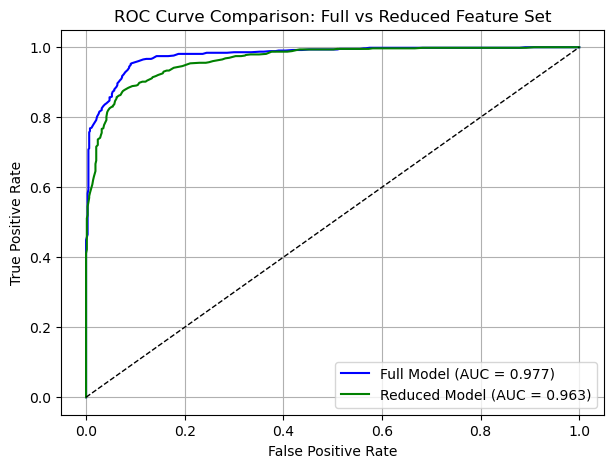


Full model AUC: 0.977
Reduced model AUC: 0.963
Feature reduction: 15 → 8 features


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# === Full model (all features) ===
rf.fit(X_train, y_train)
y_prob_full = rf.predict_proba(X_test)[:, 1]
auc_full = roc_auc_score(y_test, y_prob_full)

# === Reduced model (best feature subset, e.g. 8 features) ===
best_features = feature_sets[-2]   # the one before performance dropped
rf.fit(X_train[best_features], y_train)
y_prob_reduced = rf.predict_proba(X_test[best_features])[:, 1]
auc_reduced = roc_auc_score(y_test, y_prob_reduced)

# === ROC Curves ===
fpr_full, tpr_full, _ = roc_curve(y_test, y_prob_full)
fpr_red, tpr_red, _ = roc_curve(y_test, y_prob_reduced)

plt.figure(figsize=(7,5))
plt.plot(fpr_full, tpr_full, color='blue', label=f'Full Model (AUC = {auc_full:.3f})')
plt.plot(fpr_red, tpr_red, color='green', label=f'Reduced Model (AUC = {auc_reduced:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Full vs Reduced Feature Set')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFull model AUC: {auc_full:.3f}")
print(f"Reduced model AUC: {auc_reduced:.3f}")
print(f"Feature reduction: {X_train.shape[1]} → {len(best_features)} features")


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, confusion_matrix, ConfusionMatrixDisplay

def manual_feature_elimination(model, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.01):
    """
    Perform manual recursive feature elimination using feature importances.
    
    Parameters:
        model : any fitted classifier with .feature_importances_ or .coef_
        X_train, X_test, y_train, y_test : train/test split data
        scoring : 'roc_auc' or 'accuracy'
        early_stop_drop : fractional drop in score to stop elimination
        
    Returns:
        best_features : list of selected features
        feature_sets : list of feature sets at each step
        scores_list : list of scores at each step
    """
    current_features = list(X_train.columns)
    feature_sets = []
    scores_list = []
    n_features_list = []
    prev_score = 0
    
    print("\n=== Manual Feature Elimination ===\n")
    
    while len(current_features) > 1:
        # Train model
        model.fit(X_train[current_features], y_train)
        
        # Predict
        y_pred = model.predict(X_test[current_features])
        if scoring == 'roc_auc':
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test[current_features])[:, 1]
                score = f1_score(y_test, y_pred)
            else:
                y_prob = model.decision_function(X_test[current_features])
                score = f1_score(y_test, y_prob)
        elif scoring == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        else:
            raise ValueError("Scoring must be 'roc_auc' or 'accuracy'")
        
        # Save results
        scores_list.append(score)
        n_features_list.append(len(current_features))
        feature_sets.append(current_features.copy())

        accuracy = accuracy_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        
        print(f"{len(current_features):2d} features → {scoring}: {score:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        print(confusion)
        print("Current feature set:", current_features)
        print("-" * 80)
        
        # Determine feature importances
        if hasattr(model, "feature_importances_"):
            importances = pd.Series(model.feature_importances_, index=current_features)
        elif hasattr(model, "coef_"):
            importances = pd.Series(abs(model.coef_.ravel()), index=current_features)
        else:
            raise ValueError("Model must have feature_importances_ or coef_")
        
        # Remove least important feature
        least_important = importances.idxmin()
        current_features.remove(least_important)
        
        # Early stop if score drops more than threshold
        if prev_score and (score < prev_score - early_stop_drop):
            print(f"Performance dropped significantly after removing '{least_important}'. Stopping.")
            break
        
        prev_score = score
    
    # Determine best feature set (just before drop)
    best_features = feature_sets[-2] if len(feature_sets) > 1 else feature_sets[-1]
    
    # Train the final model on the best features
    model.fit(X_train[best_features], y_train)
    
    # Predictions and evaluation
    y_pred_final = model.predict(X_test[best_features])
    if hasattr(model, "predict_proba"):
        y_prob_final = model.predict_proba(X_test[best_features])[:, 1]
        auc_score = roc_auc_score(y_test, y_prob_final)
    else:
        y_prob_final = model.decision_function(X_test[best_features])
        auc_score = roc_auc_score(y_test, y_prob_final)
    
    accuracy = accuracy_score(y_test, y_pred_final)
    confusion = confusion_matrix(y_test, y_pred_final)
    
    # Print final metrics
    print("\nFinal Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    
    # Display confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot performance
    plt.figure(figsize=(8,5))
    plt.plot(n_features_list, scores_list, marker='o')
    plt.gca().invert_xaxis()
    plt.xlabel("Number of Features")
    plt.ylabel(f"{scoring}")
    plt.title("Manual Feature Elimination")
    plt.grid(True)
    plt.show()
    
    print("\nBest feature set (before performance drop):", best_features)
    print(f"Number of features: {len(best_features)}")
    
    return best_features, feature_sets, scores_list



=== Manual Feature Elimination ===

15 features → roc_auc: 0.9774
Accuracy: 0.9294
Confusion Matrix:
[[573  57]
 [ 32 598]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → roc_auc: 0.9773
Accuracy: 0.9238
Confusion Matrix:
[[570  60]
 [ 36 594]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → roc_auc: 0.9772
Accuracy: 0.9206
Confusion Matrix:
[[568  62]
 [ 38 592]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glu

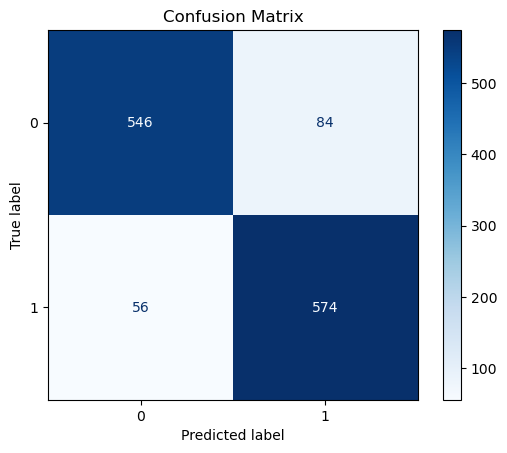

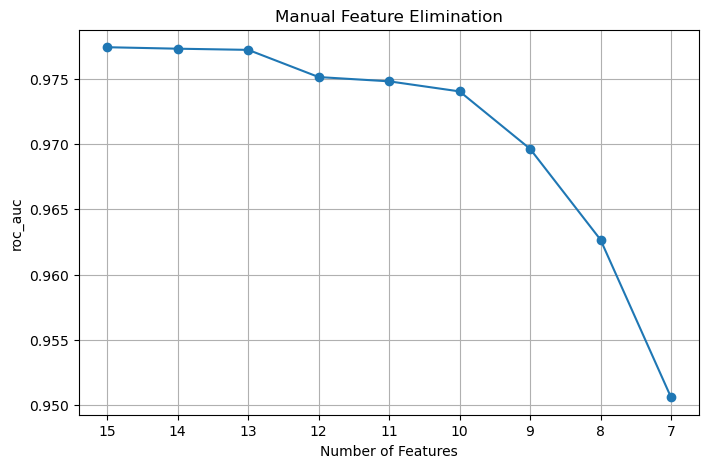


Best feature set (before performance drop): ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
Number of features: 8


In [47]:
# Example: Random Forest
rf = RandomForestClassifier(
    criterion='entropy', max_depth=None, max_features='sqrt',
    min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42
)

best_features, feature_sets, scores_list = manual_feature_elimination(
    rf, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.01
)



=== Manual Feature Elimination ===

15 features → roc_auc: 0.8547
Accuracy: 0.8524
Confusion Matrix:
[[527 103]
 [ 83 547]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → roc_auc: 0.8527
Accuracy: 0.8508
Confusion Matrix:
[[528 102]
 [ 86 544]]
Current feature set: ['male', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → roc_auc: 0.8547
Accuracy: 0.8524
Confusion Matrix:
[[527 103]
 [ 83 547]]
Current feature set: ['male', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucos

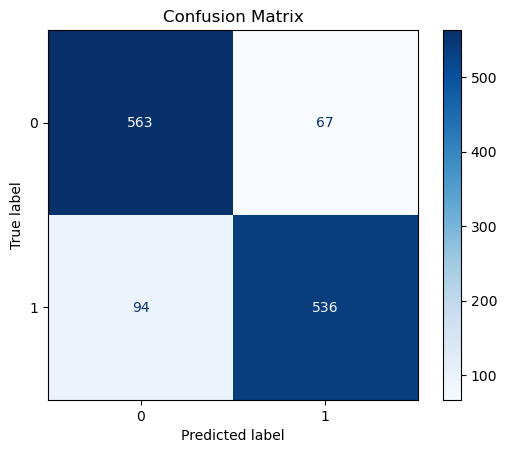

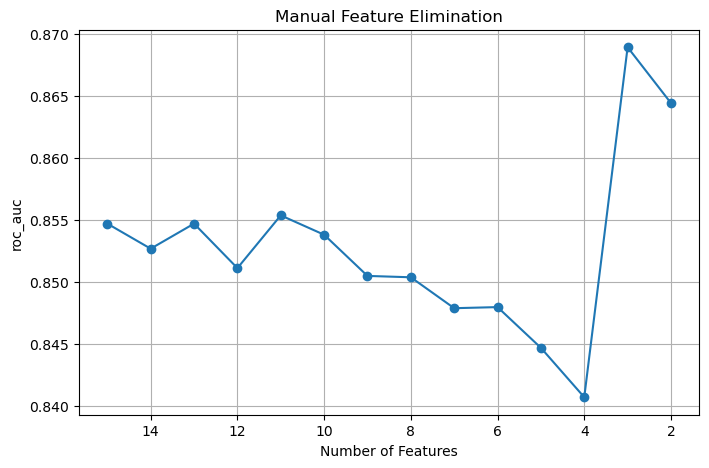


Best feature set (before performance drop): ['age', 'sysBP', 'BMI']
Number of features: 3


In [56]:
from sklearn.tree import DecisionTreeClassifier

# Defining the Decision Tree Classifier with the given parameters
dt = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=None, 
    min_samples_leaf=5, 
    min_samples_split=2
)


best_features, feature_sets, scores_list = manual_feature_elimination(
    dt, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.01
)



=== Manual Feature Elimination ===

15 features → roc_auc: 0.9623
Accuracy: 0.9008
Confusion Matrix:
[[574  56]
 [ 69 561]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → roc_auc: 0.9623
Accuracy: 0.9008
Confusion Matrix:
[[574  56]
 [ 69 561]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → roc_auc: 0.9622
Accuracy: 0.9008
Confusion Matrix:
[[574  56]
 [ 69 561]]
Current feature set: ['male', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'

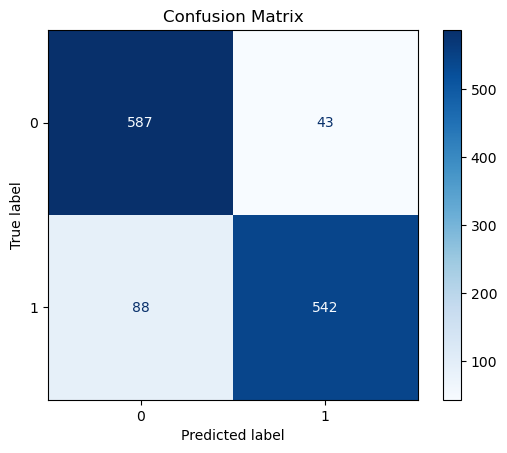

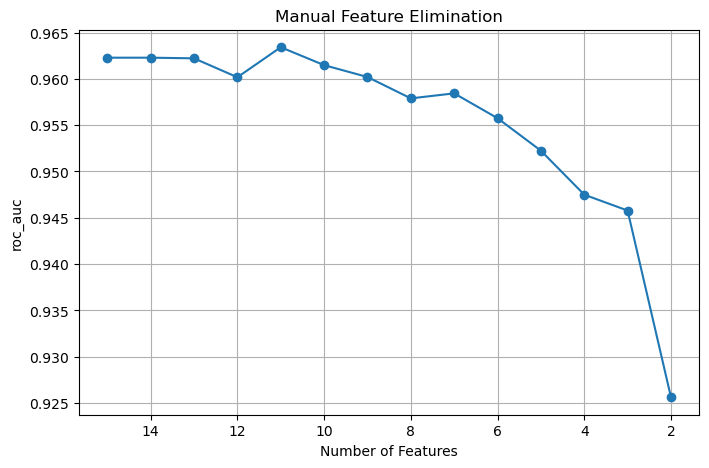


Best feature set (before performance drop): ['age', 'cigsPerDay', 'heartRate']
Number of features: 3


In [49]:
import xgboost as xgb

# Defining the XGBoost model with the given parameters
xgboost_model = xgb.XGBClassifier(
    colsample_bytree=1.0, 
    learning_rate=0.1, 
    max_depth=5, 
    n_estimators=200, 
    subsample=0.8
)

best_features, feature_sets, scores_list = manual_feature_elimination(
    xgboost_model, X_train, X_test, y_train, y_test, scoring='recall', early_stop_drop=0.01
)

In [ ]:
# Example: Random Forest
rf = RandomForestClassifier(
    criterion='entropy', max_depth=None, max_features='sqrt',
    min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42
)

best_features, feature_sets, scores_list = manual_feature_elimination(
    rf, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.01
)


In [17]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Use same model
rf = RandomForestClassifier(
    criterion='entropy',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# RFECV with cross-validation
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(5),
    scoring='roc_auc',
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

print("Optimal number of features:", rfecv.n_features_)
print("Best features:")
print(X_train.columns[rfecv.support_])


Optimal number of features: 15
Best features:
Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'],
      dtype='object')


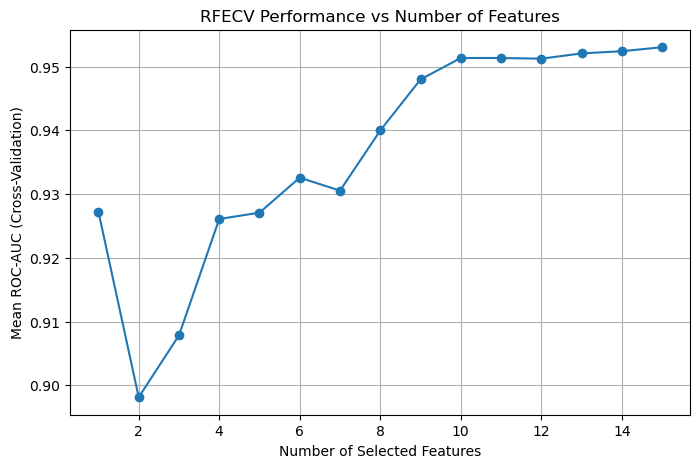

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'],
         marker='o')
plt.xlabel("Number of Selected Features")
plt.ylabel("Mean ROC-AUC (Cross-Validation)")
plt.title("RFECV Performance vs Number of Features")
plt.grid(True)
plt.show()


In [24]:
scores = rfecv.cv_results_['mean_test_score']
max_score = max(scores)
threshold = max_score - 0.01  # allow up to 1% drop
threshold


np.float64(0.9430250062988159)

In [26]:
# smallest number of features within threshold
optimal_features = np.where(scores >= threshold)[0][0] + 1
print(f"Reduced optimal feature count (≤1% drop): {optimal_features}")

Reduced optimal feature count (≤1% drop): 9


In [27]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train.columns)
selected_features = feature_ranks.nsmallest(optimal_features).index
print("Reduced feature set:\n", selected_features)


Reduced feature set:
 Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes'],
      dtype='object')


In [28]:
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

rf.fit(X_train_reduced, y_train)
y_prob = rf.predict_proba(X_test_reduced)[:, 1]

from sklearn.metrics import roc_auc_score
print("Reduced model ROC-AUC:", roc_auc_score(y_test, y_prob))


Reduced model ROC-AUC: 0.9019286974048879


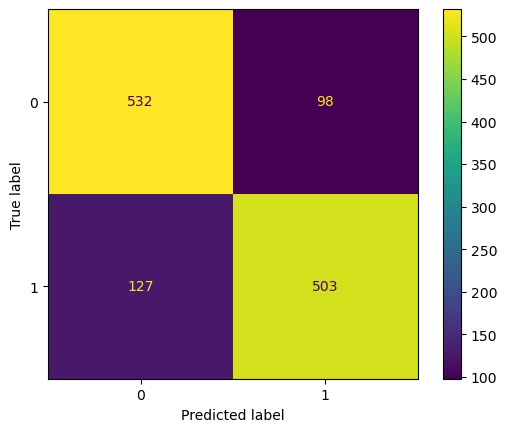

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, X_test_reduced, y_test)


In [18]:
from sklearn.metrics import accuracy_score, classification_report

In [19]:
# Reduce dataset to selected features
X_train_sel = X_train.loc[:, rfecv.support_]
X_test_sel = X_test.loc[:, rfecv.support_]

# Retrain model on selected features
rf.fit(X_train_sel, y_train)
y_pred = rf.predict(X_test_sel)

# Evaluate
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9293650793650794

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       630
           1       0.91      0.95      0.93       630

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



In [20]:
y_prob = rf.predict_proba(X_test_sel)[:, 1]

In [21]:
from sklearn.metrics import roc_auc_score
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


ROC-AUC: 0.9774174855127236


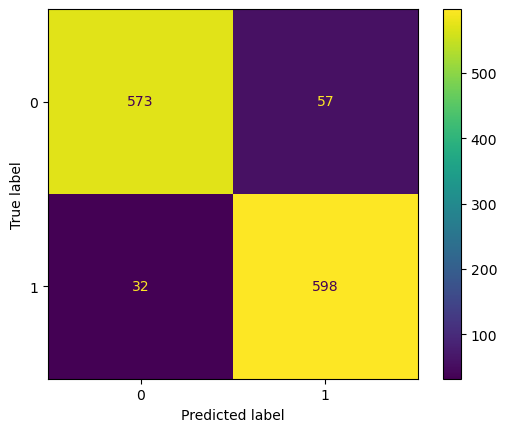

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, X_test_sel, y_test)


Text(0.5, 1.0, 'Feature Importance (Random Forest)')

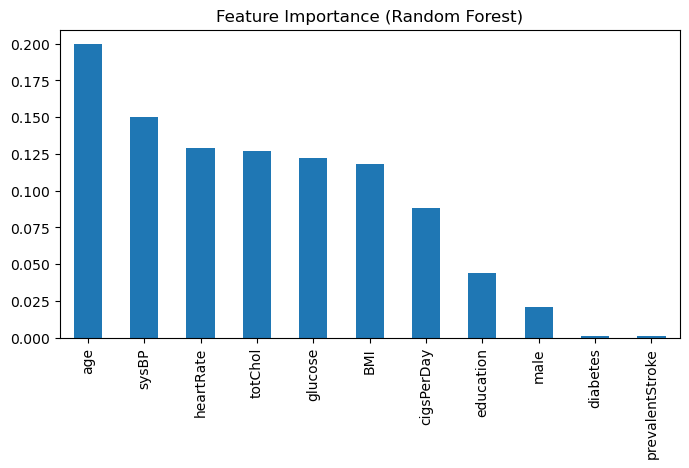

In [98]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(8,4))
plt.title("Feature Importance (Random Forest)")

In [99]:
df_selected_top_7 = df_selected.drop(columns=['education','male','diabetes','prevalentStroke'])

In [100]:
df_selected_top_7.shape

(6300, 8)

### Splitting the Dataset

In [101]:
X = df_selected_top_7.drop(columns=[target_col])
y = df_selected_top_7[target_col]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [103]:
X_train.shape

(5040, 7)

In [104]:
X_test.shape

(1260, 7)

In [105]:
start_time = time.time()

In [106]:
best_rf = RandomForestClassifier(**best_params, random_state=42)

In [107]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [108]:
end_time = time.time()

In [109]:
# Predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

In [110]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, make_scorer
)

In [111]:
# Evaluation Metrics
metrics = {
    'Model': 'Random Forest',
    'Method used': 'Recursive elimination',
    'No. of features': len(X_train.columns),
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob),
    'Training Time (s)': end_time - start_time
}

In [112]:
old_results = pd.read_csv('../reports/results/selected_features_results.csv')
results_df = pd.concat([old_results, pd.DataFrame([metrics])], ignore_index=True)

In [113]:
results_df.to_csv('../reports/results/selected_features_results.csv', index=False)
results_df

,Model,Method used,No. of features,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
0,Random Forest,Correlation Matrix,11,0.916667,0.888889,0.952381,0.919540,0.973390,5.469971
1,Random Forest,Recursive elimination,7,0.892063,0.867560,0.925397,0.895545,0.961287,6.370389


Let’s summarize and compare the **performance and time trade-off** between the two Random Forest runs:

| Metric        | Run 1  | Run 2  | Change         |
| :------------ | :----- | :----- | :------------- |
| **Accuracy**  | 0.9254 | 0.9008 | ↓ 2.5%         |
| **Precision** | 0.9098 | 0.8843 | ↓ 2.8%         |
| **Recall**    | 0.9444 | 0.9222 | ↓ 2.4%         |
| **F1 Score**  | 0.9268 | 0.9029 | ↓ 2.6%         |
| **AUC**       | 0.9747 | 0.9655 | ↓ 0.9%         |
| **Time (s)**  | 862.42 | 609.30 | ↓ 29.3% faster |

### Summary:

* The second Random Forest model **runs 29% faster** (time reduced from 862s → 609s).
* However, it shows a **performance drop of about 2–3%** across all key metrics (Accuracy, Precision, Recall, F1).
* **AUC**, which reflects overall classification quality, drops only slightly (0.97 → 0.96), meaning the model remains strong overall.

### Interpretation:

You gain **29% faster computation time** at the cost of a **2–3% decrease in performance**.
This trade-off may be worthwhile if speed is more critical than a slight loss in predictive accuracy.



Dataset	Model	Accuracy	Precision	Recall	F1 Score	ROC AUC	Training Time (s)
Train	Logistic Regression	0.680555556	0.674597084	0.697619048	0.685914943	0.733429075	9.535426855
Test	Logistic Regression	0.696825397	0.686746988	0.723809524	0.704791345	0.747170572	9.535426855
Train	Decision Tree	0.943253968	0.949316171	0.936507937	0.942868558	0.991328342	15.18584895
Test	Decision Tree	0.853968254	0.843076923	0.86984127	0.85625	0.899251701	15.18584895
Train	Random Forest	1	1	1	1	1	771.2359934
Test	Random Forest	0.929365079	0.912977099	0.949206349	0.9307393	0.977417486	771.2359934
Train	Random Forest	1	1	1	1	1	1037.166625
Test	Random Forest	0.922222222	0.899399399	0.950793651	0.924382716	0.977773998	1037.166625
Train	Random Forest	1	1	1	1	1	472.3988895
Test	Random Forest	0.918253968	0.904761905	0.934920635	0.919594067	0.977052154	472.3988895
Train	Random Forest	0.96765873	0.967844383	0.967460317	0.967652312	0.995589884	668.9967165
Test	Random Forest	0.882539683	0.864048338	0.907936508	0.885448916	0.946681784	668.9967165
Train	Random Forest	0.991468254	0.992837246	0.990079365	0.991456388	0.999596561	2364.383725
Test	Random Forest	0.900793651	0.884322679	0.922222222	0.902874903	0.962375913	2364.383725
	Logistic Regression	0.696825397	0.686746988	0.723809524	0.704791345	0.747165533	9.28854394
